<center>

# Utilizing RNNs to Control Nonlinear Dynamic Systems
![Closed-loop Control System](./docs/visualizations/closed-loop-control-system.png) \
*Figure 1: Block diagram of a closed-loop control system with an RNN as a controller.*

</center>

## Introduction
The objective of this project is to develop a method for utilizing recurrent neural networks (RNNs) to control nonlinear dynamic systems. We will begin by selecting the Van der Pol system, an unstable system that exhibits oscillations even with no input. Although feedback linearization can be used to convert the Van der Pol system to a linear system and apply classical linear control methods to stabilize it, this method is often considered heuristic and may not be optimal for all nonlinear dynamic systems. Therefore, we aim to propose a more general method (utilizing RNNs) that can be applied to a broader range of dynamic systems.

<center>

</center>

We will start by using a simple proportional-integral-derivative (PID) controller in a closed-loop control system to demonstrate the difficulty of controlling such a system. We will also attempt to introduce feedback linearization, but its necessity is unclear at this point. Then, we will train an RNN to act as a controller in the closed-loop control system. Supervised learning will be used to train the RNN with the goal of stabilizing the Van der Pol system, meaning that the output of the system remains at a desired constant value set as the input of the closed-loop system. We will apply different set-points to the input of the closed-loop system during training and expect the output to be the same as the input set-point.

However, one issue in training the RNN as a controller is that we do not know the desired output of the controller, and therefore, we cannot train it in a supervised manner. One approach to overcome this challenge is using reinforcement learning and letting the RNN learn by the outcome of its generated sequence (control signal u) that is fed to the nonlinear dynamic system. Although this process may be time-consuming, it is worth exploring further. Another approach is to use another RNN to identify the dynamic system itself. Once we have an RNN that can behave (almost) exactly like our real dynamic system, we can replace the real system with the identified RNN and consider the combination of the two RNNs as a whole (one RNN for the controller and the other RNN to replace the real dynamic system). In this configuration, we can have both the input and the desired output, allowing us to apply supervised learning to train the controller RNN. We will begin by training the second RNN to identify the real dynamic system offline. Then, we will put it in the closed-loop system and fix its weights while optimizing the weights of the first RNN (controller).

## Import Libraries

In [39]:
# Import libraries
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
import math
import os, sys
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter
import torch.optim as optim

# Define datasets path
SYS_DATASET_PATH = "./data/van_der_pol.pt"
PID_DATASET_PATH = "./data/pid_data.pt"
CLOSED_LOOP_SYS_DATASET_PATH = "./data/closed_loop_sys_data.pt"

# Define execution device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # (F) What is the use of this?

## System Classes

In [40]:
class VanDerPol:
    def __init__(self, mu, dt):
        self.mu = mu  # system parameter
        self.dt = dt  # time step
        self.dt2 = dt * dt  # dt²

    def next_output(self, u, y0, y1):
        return (
            2 * y1
            - y0
            + self.mu * self.dt * (1 - y0 * y0) * (y1 - y0)
            + self.dt2 * (u - y0)
        )

    def run(self, u, t0):
        ts = t0 + np.array([self.dt * i for i in range(len(u))])
        y = np.zeros(len(ts))

        # initial conditions:
        y[0] = 0.0
        dy_dt = 0.0
        y[1] = y[0] + self.dt * dy_dt

        for i in range(2, len(ts)):
            y[i] = self.next_output(u[i], y[i - 2], y[i - 1])

        return ts, y

    def run_controlled(self, reference, t0, controller):
        controller.reset()
        ts = t0 + np.array([self.dt * i for i in range(len(reference))])
        y = np.zeros(len(ts))
        u = np.zeros(len(ts))
        e = np.zeros(len(ts))

        # initial conditions:
        y[0] = 0.0
        dy_dt = 0.0
        y[1] = y[0] + self.dt * dy_dt

        for i in range(2, len(ts)):
            e[i] = reference[i] - y[i - 1]
            u[i] = controller(e[i])
            y[i] = self.next_output(u[i], y[i - 2], y[i - 1])

        return ts, y, u, e

In [41]:
class PIDController:
    def __init__(self, kp, ki, kd, out_min, out_max, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.out_min = out_min
        self.out_max = out_max
        self.dt = dt

        self.reset()

    def reset(self):
        self.last_error = 0
        self.integral = 0

    def __call__(self, error) -> Any:
        return self.compute(error)

    def compute(self, error):
        derivative = (error - self.last_error) / self.dt
        self.integral += error * self.dt
        self.last_error = error

        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)

        # soft clamp output using tanh function
        a = self.out_min
        b = self.out_max
        output = (1 + math.tanh(output)) * (b - a) / 2 + a

        return output

In [42]:
class SystemRNN(nn.Module):
    def __init__(
        self,
        input_size=1,
        hidden_size=200,
        output_size=1,
        num_layers=1,
        nonlinearity="tanh",
        dropout=0.0,
        rnn_type="lstm",
        name = ""
    ):
        super(SystemRNN, self).__init__()
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.name = name
        
        if rnn_type == "vanilla":
            self.rnn = nn.RNN(
                input_size,
                hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity=nonlinearity,
                dropout=dropout,
            )
        else:
            self.rnn = nn.LSTM(
                input_size,
                hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )

        self.fc = nn.Linear(hidden_size, output_size)
        self.reset()

    def forward(self, input):
        if isinstance(input, np.ndarray):
            x = torch.from_numpy(input.astype(np.float32))
        elif isinstance(input, float):
            x = torch.tensor(input, dtype=torch.float32)
        else:
            x = input

        # Convert input shape to [seq_length, input_size=1]
        if x.dim() == 0:
            x = x.view(1, 1)
        elif x.dim() == 1:
            x = x.view(*x.shape, 1)

        if x.dim() == 3:
            # Input shape is [batch_size, seq_length, input_size]
            batch_size = x.shape[0]
            seq_length = x.shape[1]
        elif x.dim() == 2:
            # Input shape is [seq_length, input_size]
            batch_size = None
            seq_length = x.shape[0]

        # Reset hidden state to zero if input is a sequence
        if seq_length > 1:
            self.reset(batch_size)

        x = x.to(DEVICE)

        x, self.h = self.rnn(x, self.h)
        out = self.fc(x)

        if isinstance(input, np.ndarray):
            out = out.squeeze().cpu().detach().numpy()
        elif isinstance(input, float):
            out = out.squeeze().cpu().detach().item()
            
        return out

    def reset(self, batch_size=None):
        h0 = (
            torch.zeros(self.num_layers, self.hidden_size).to(DEVICE)
            if batch_size is None
            else torch.zeros(self.num_layers, batch_size, self.hidden_size).to(DEVICE)
        )
        self.h = h0 if self.rnn_type == "vanilla" else (h0, h0.clone())

In [43]:
class ControllerRNN(SystemRNN):
    def __init__(
        self,
        out_min=-3,
        out_max=3,
        input_size=1,
        hidden_size=200,
        output_size=1,
        num_layers=1,
        nonlinearity="tanh",
        dropout=0,
        rnn_type="lstm",
        name = ""
    ):
        super().__init__(
            input_size,
            hidden_size,
            output_size,
            num_layers,
            nonlinearity,
            dropout,
            rnn_type,
            name=name
        )
        self.out_min = out_min
        self.out_max = out_max

    def forward(self, input):
        output = super().forward(input)

        if not isinstance(output, torch.Tensor):
            output = torch.tensor(output)
            
        # soft clamp output using tanh function
        a = self.out_min
        b = self.out_max
        output = (1 + torch.tanh(output)) * (b - a) / 2 + a

        if isinstance(input, np.ndarray):
            output = output.numpy()
        elif isinstance(input, float):
            output = output.item()
        
        return output

In [44]:
class ClosedLoopSysRNN(nn.Module):
    def __init__(
        self,
        sys_path: str,
        ctl_path:str,
        ref_size = 1,
    ):
        super().__init__()

        self.name = "Closed Loop System RNN"
        self.ref_size = ref_size

        # Load System RNN
        self.sys_rnn: SystemRNN = torch.load(sys_path)
        # Fix all the parameters of the system RNN module
        for param in self.sys_rnn.parameters():
            param.requires_grad = False

        # Load Controller RNN
        self.ctl_rnn: ControllerRNN = torch.load(ctl_path)

    # r: Reference Signal = [batch_size, sequence_length, 1]
    def forward(self, r: torch.Tensor):
        
        ref_size = self.ref_size
        control_size = self.sys_rnn.rnn.input_size

        if r.dim() == 3:
            batch_size = r.shape[0]
        else:
            batch_size = 1
            r = r.view(1, *r.shape)

        sequence_length = r.shape[1]

        # Reset hidden states to zero
        self.sys_rnn.reset(batch_size)
        self.ctl_rnn.reset(batch_size)

        r = r.to(DEVICE)

        if r.shape != (batch_size, sequence_length, ref_size):
            raise ValueError(
                f"The shape of r is {r.shape}, but it should be ({batch_size}, {sequence_length}, {ref_size})"
            )
        
        y = torch.empty(batch_size, sequence_length, ref_size).to(DEVICE)
        y0 = torch.zeros(batch_size, ref_size).to(DEVICE)

        # Control signal
        self.u = torch.empty(batch_size, sequence_length, control_size)

        for t in range(sequence_length):
            ref = r[:, t, :]
            e = ref - y0

            uc = self.ctl_rnn(e.view(batch_size, 1, ref_size))
            self.u[:, t, :] = uc.view(batch_size, control_size)

            y0 = self.sys_rnn(uc)
            y0 = y0.view(batch_size, ref_size)

            y[:, t, :] = y0

        return y

## Helper Functions

In [45]:
def simulate_sys_with_controller(van_der_pol_sys, controller):
    t0 = 0
    tf = 10.0  # final time
    ts = np.zeros(int(tf / van_der_pol_sys.dt))

    u_fig = plt.figure()
    y_fig = plt.figure()
    e_fig = plt.figure()

    for reference in np.arange(1.5, -1.6, -0.5):
        ts, y, u, e = van_der_pol_sys.run_controlled(
            np.ones(len(ts)) * reference, t0, controller
        )
        # Plot the results
        plt.figure(y_fig)
        plt.plot(ts, y, label=f"r = {reference}")

        plt.figure(u_fig)
        plt.plot(ts, u, label=f"r = {reference}")

        plt.figure(e_fig)
        plt.plot(ts, e, label=f"r = {reference}")

    def configure_figure(
        u_fig, xlabel, ylabel, title, grid: bool = True, legend_loc="upper right"
    ):
        plt.figure(u_fig)
        plt.legend(loc=legend_loc)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)

    configure_figure(
        y_fig, "Time (s)", "y(t)", "Van der Pol System Output under Control"
    )
    configure_figure(u_fig, "Time (s)", "u(t)", "Controller Output")
    configure_figure(e_fig, "Time (s)", "e(t)", "Error Signal (Controller Input)")

In [46]:
def print_model_parameters_info(model):
    # Count the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total parameters:", total_params)
    print("Trainable parameters:", trainable_params)

In [47]:
def plot_sample_signal_data(
    dataset,
    net: SystemRNN = None,
    num_samples=1,
    shuffle=True,
    input_title="Input Signal",
    output_title="Output Signal",
):
    # Create a data loader for the dataset
    sample_loader = DataLoader(dataset, batch_size=num_samples, shuffle=shuffle)
    input_signals, output_signals = next(iter(sample_loader))
    if hasattr(dataset, "ts"):
        ts = dataset.ts
        input_label = dataset.input_label
        output_label = dataset.output_label
    else:
        ts = dataset.dataset.ts
        input_label = dataset.dataset.input_label
        output_label = dataset.dataset.output_label
    with torch.no_grad():
        for input_signal, output_signal in zip(input_signals, output_signals):
            plt.figure(figsize=(8, 4))

            # Plot the generated input signal
            plt.subplot(1, 2, 1)
            plt.plot(ts, torch.squeeze(input_signal))
            plt.xlabel("Time (s)")
            plt.ylabel(input_label)
            plt.title(input_title)
            plt.grid((True))

            # Plot the generated output signal
            plt.subplot(1, 2, 2)
            plt.plot(ts, torch.squeeze(output_signal), label="Real Output")

            if net is not None:
                predicted_signal = net(input_signal)

                plt.plot(
                    ts,
                    torch.squeeze(predicted_signal.cpu()),
                    label=net.name + " Output",
                )
            plt.xlabel("Time (s)")
            plt.ylabel(output_label)
            plt.title(output_title)
            if net is not None:
                plt.legend()
            plt.grid(True)

            plt.show()

In [48]:
def generate_random_steps(
    num_steps,
    step_width,
    max_step_height,
    max_signal_val,
):
    # Initialize the signal with zeros
    signal = np.zeros(num_steps * step_width)
    current_val = 0  # Start from 0

    for i in range(num_steps):
        # Generate a random step between -step_size and step_size
        step = np.random.uniform(-max_step_height, max_step_height)
        # Update the current value with the step
        current_val += step
        # Clip the current value to be within the maximum value
        current_val = np.clip(current_val, -max_signal_val, max_signal_val)
        # Assign the current value to the signal
        signal[i * step_width : (i + 1) * step_width] = current_val

    return signal

In [49]:
def train_validate(
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer,
    criterion,
    net: SystemRNN,
):
    writer = SummaryWriter("../logs")
    
    print(f"Training {net.name}...")
    print_model_parameters_info(net)

    # Get the first batch
    iterator = iter(train_loader)
    first_batch = next(iterator)
    # Get the total number of items in a batch of data
    total_items = first_batch[0].numel()
    print("Total data items per batch:", total_items)

    best_val_loss = sys.float_info.max

    # Train the network
    for epoch in range(epochs):  # Loop over the dataset multiple times
        net.train()
        train_loss = 0.0
        num_batches = 0
        # input/target [batch_size,  sequence_length]
        for inputs, ground_truth in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, ground_truth.to(DEVICE))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

        train_loss /= num_batches
        val_loss = test(val_loader, criterion, net)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(), "best.pth")

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        print(
            f"[{int((epoch + 1.0) / epochs * 100)}%] train loss: {train_loss:.3f}, val loss: {val_loss:.3f}"
        )

    writer.flush()
    writer.close()

    net.load_state_dict(torch.load("best.pth"))


def test(test_loader: DataLoader, criterion, net: SystemRNN):
    net.eval()
    loss = 0
    num_batches = 0

    with torch.no_grad():  # since we're not training, we don't need to calculate the gradients for our outputs
        for inputs, ground_truth in test_loader:
            outputs = net(inputs)
            loss += criterion(outputs, ground_truth.to(DEVICE))
            num_batches += 1

    return loss / num_batches

In [50]:
def train_if_needed(rnn_model, dataset, sys_rnn_file_path, learning_rate = 0.001, epochs = 300):
    criterion = nn.MSELoss()

    # Define the sizes of the training, validation, and test sets
    train_size, val_size, test_size = 0.6, 0.2, 0.2

    # Use random_split to split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    batch_size = len(train_dataset) // 10

    if not os.path.isfile(sys_rnn_file_path):
        os.makedirs(os.path.dirname(sys_rnn_file_path), exist_ok=True)

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
        )

        train_validate(
            epochs,
            train_loader,
            val_loader,
            optim.Adam(rnn_model.parameters(), lr=learning_rate),
            criterion,
            rnn_model,
        )

        torch.save(rnn_model, sys_rnn_file_path)
    else:
        rnn_model = torch.load(sys_rnn_file_path)

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )
    test_loss = test(test_loader, criterion, rnn_model)
    print(f"{rnn_model.name} Test loss = {test_loss:.3f}")

    plot_sample_signal_data(
        test_dataset,
        net=rnn_model,
        num_samples=3,
    )

## Dataset Classes

In [51]:
class DynamicSystemDataset(Dataset):
    def __init__(
        self, system, data_count, num_steps, step_width, max_step_height, max_signal_val
    ):
        tensor_shape = (data_count, num_steps * step_width, 1)

        self.inputs = torch.empty(tensor_shape, dtype=torch.float32)
        self.outputs = torch.empty(tensor_shape, dtype=torch.float32)

        for i in tqdm(range(data_count)):
            u = generate_random_steps(
                num_steps, step_width, max_step_height, max_signal_val
            )
            ts, y = system.run(u, 0)
            self.inputs[i, :, 0] = torch.from_numpy(u)
            self.outputs[i, :, 0] = torch.from_numpy(y)

        self.ts = ts
        self.input_label = "u(t)"
        self.output_label = "y(t)"
        
        # Save dataset
        os.makedirs(os.path.dirname(SYS_DATASET_PATH), exist_ok=True)
        torch.save(self, SYS_DATASET_PATH)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [52]:
class PIDDataset(Dataset):
    def __init__(
        self,
        van_der_pol_sys,
        pid,
        data_count,
        num_steps,
        step_width,
        max_step_height,
        max_signal_val,
    ):
        seq_len = num_steps * step_width
        tensor_shape = (data_count, seq_len, 1)

        self.inputs = torch.empty(tensor_shape, dtype=torch.float32)
        self.outputs = torch.empty(tensor_shape, dtype=torch.float32)

        for i in tqdm(range(data_count)):
            reference = generate_random_steps(
                num_steps, step_width, max_step_height, max_signal_val
            )
            ts, y, u, e = van_der_pol_sys.run_controlled(reference, 0, pid)

            self.inputs[i, :, 0] = torch.from_numpy(e)
            self.outputs[i, :, 0] = torch.from_numpy(u)

        self.ts = ts
        self.input_label = "e(t)"
        self.output_label = "u(t)"

        # Save dataset
        os.makedirs(os.path.dirname(PID_DATASET_PATH), exist_ok=True)
        torch.save(self, PID_DATASET_PATH)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


In [53]:
class ClosedLoopSysDataset(Dataset):
    def __init__(
        self,
        van_der_pol_sys,
        data_count,
        num_steps,
        step_width,
        max_step_height,
        max_signal_val,
    ):
        tensor_shape = (data_count, num_steps * step_width, 1)

        self.inputs = torch.empty(tensor_shape, dtype=torch.float32)
        self.outputs = torch.empty(tensor_shape, dtype=torch.float32)

        for i in tqdm(range(data_count)):
            random_steps = generate_random_steps(
                num_steps, step_width, max_step_height, max_signal_val
            )
            self.inputs[i, :, 0] = torch.from_numpy(random_steps)
            self.outputs[i, :, 0] = torch.from_numpy(random_steps)

        self.ts = np.array(
            [van_der_pol_sys.dt * i for i in range(num_steps * step_width)]
        )
        self.input_label = "r(t)"
        self.output_label = "y(t)"

        # Save dataset
        os.makedirs(os.path.dirname(CLOSED_LOOP_SYS_DATASET_PATH), exist_ok=True)
        torch.save(self, CLOSED_LOOP_SYS_DATASET_PATH)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

## Simulate the Van der Pol System
<center>

![Van der Pol System](./docs/visualizations/van-der-pol-system.png) \
*Figure 2: Van der Pol System.*

</center>

The Van der Pol system is a nonlinear dynamical system that can be described by the following second-order ordinary differential equation:

$$\frac{d^2y}{dt^2} = \mu(1-y^2)\frac{dy}{dt} - y + u(t)$$

where $u(t)$ and $y(t)$ are the input and the output of the system respectively and $\mu$ is a parameter that controls the strength of the damping and the nonlinearity. We set $\mu = 1$ for our simulations.

We first try to simulate the Van der Pol system and investigate its behavior for different values of input $u(t)$

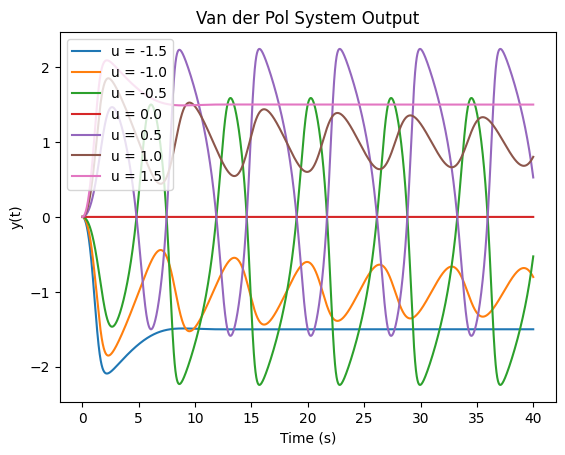

In [54]:
# Instantiate the VanDerPol system
van_der_pol_sys = VanDerPol(mu=1, dt=0.01)

t0 = 0
tf = 40.0  # final time
ts = np.zeros(int(tf / van_der_pol_sys.dt))

for u in np.arange(-1.5, 1.6, 0.5):
    ts, y = van_der_pol_sys.run(np.ones(len(ts)) * u, t0)
    # Plot the results
    plt.plot(ts, y, label=f"u = {u}")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.title("Van der Pol System Output")
plt.show()

It can be observed that the Van der Pol system exhibits more unstable behavior at zero inputs. We will now attempt to stabilize the output of the system at zero using a closed-loop system with a simple PID controller.

## Simple PID Controller

??? Add Diagram ???

A PID controller is a feedback control mechanism widely used in engineering systems to regulate a process variable such as temperature, pressure, flow rate, or speed. PID stands for Proportional-Integral-Derivative, which are the three terms that compose the controller.

The proportional term computes an output proportional to the error between the desired setpoint and the actual process variable. The integral term integrates the error over time and adds a corrective term to account for any accumulated error. The derivative term predicts the future error based on the rate of change of the error, allowing the controller to respond more quickly to changes in the process variable.

The three terms can be adjusted through tuning parameters to optimize the controller's performance for a specific process. PID controllers are widely used in a variety of applications, including industrial control systems, robotics, and automation.

It seems that the PID controller is working well. Perhaps we should consider selecting a different system or waiting to evaluate the performance of the RNN. 

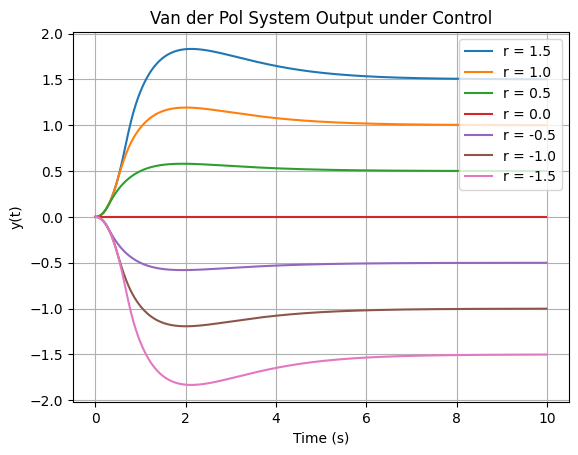

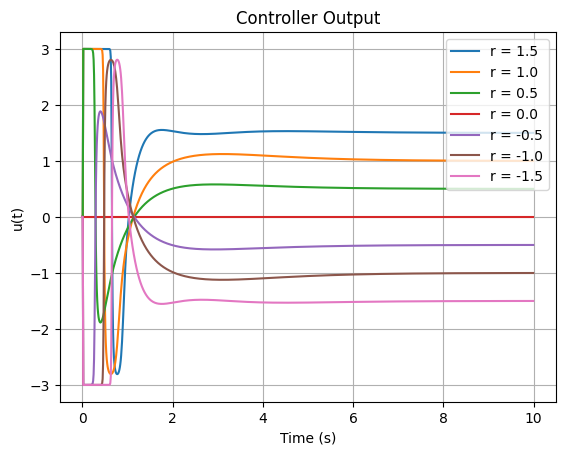

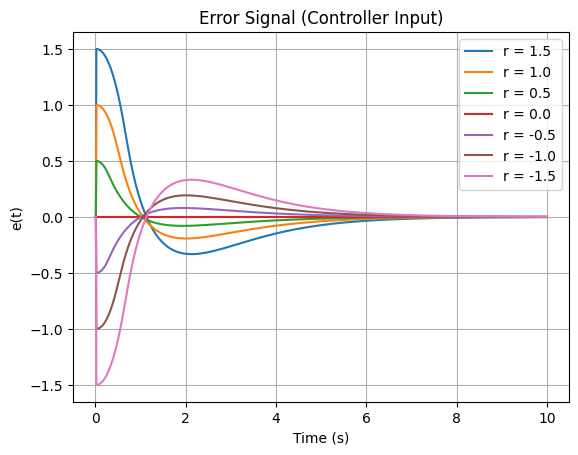

In [55]:
kp, ki, kd = 20, 10, 10
pid = PIDController(kp, ki, kd, -3, 3, dt=van_der_pol_sys.dt)

simulate_sys_with_controller(van_der_pol_sys, pid)

## System Identification Using an RNN
System identification refers to the process of determining the mathematical model of a physical system from experimental data. When using recurrent neural networks (RNNs) for system identification, the goal is to estimate the dynamics of the system using the collected input-output data.

The Van der Pol system is a well-known nonlinear dynamical system that exhibits self-sustained oscillations. To use an RNN to identify the Van der Pol system, we first need to collect input-output data from the system, typically by exciting the system with different input signals and recording its output.

### Generating Input and Output Signals

The generated input signals for the Van der Pol system consist of a sequence of random steps. To generate these signals, we first specify the number of steps in the sequence, the maximum size of each step, and the maximum value of the signal.

Then, for each step in the sequence, we generate a random step size between negative and positive `max_step_height`. We add this step size to the current value of the signal, and then clip the resulting value to be within the range of `-max_signal_val` to `+max_signal_val`. The resulting value is then used as the signal value for the corresponding time interval.

We repeat this process for each step in the sequence, resulting in a signal consisting of a sequence of random steps. These signals can be used as input signals to the Van der Pol system to record its output for system identification purposes.

**Generating the Dataset for the Identifier RNN**

100%|██████████| 2000/2000 [00:07<00:00, 261.13it/s]


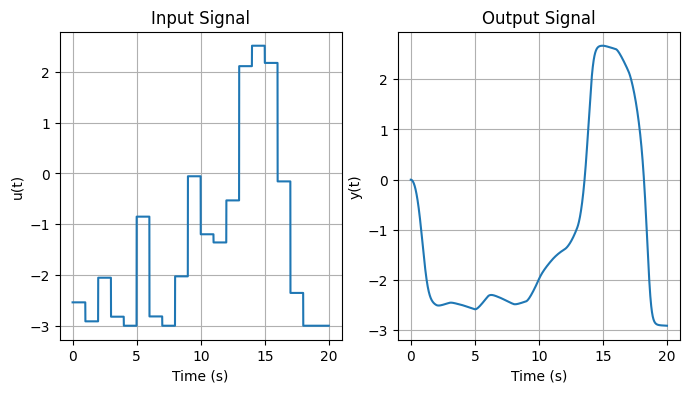

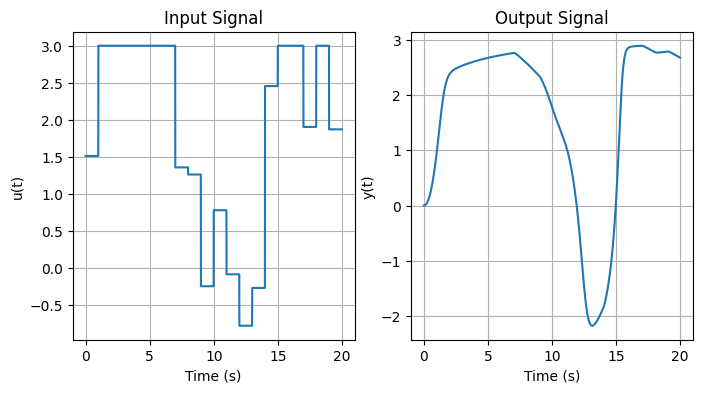

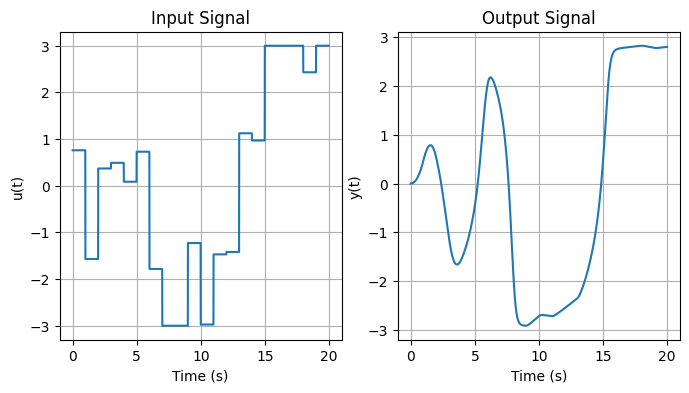

In [56]:
# Generate dataset from system's input and output
sys_dataset = (
    DynamicSystemDataset(
        van_der_pol_sys,
        data_count=2000,
        num_steps=20,
        step_width=100,
        max_step_height=3,
        max_signal_val=3,
    )
    if not os.path.isfile(SYS_DATASET_PATH)
    else torch.load(SYS_DATASET_PATH)
)

plot_sample_signal_data(sys_dataset, num_samples=3)

Some input and output signals are plotted using matplotlib. The left plots show the generated input signals over time, and the second plots show the output signals of the Van der Pol system in response to the input signals. These signals can be used for system identification purposes to train an RNN to model the Van der Pol system.

### The Van der Pol RNN

In an RNN, the hidden state at each time step is computed based on the input at that time step and the hidden state from the previous time step. This architecture enables the network to capture temporal dependencies in the data, making it well-suited for modeling dynamic systems.

To identify the VanDerPol system using an RNN, we utilize a dataset of input-output pairs created previously. We train the RNN on this dataset to learn the underlying dynamics of the system. The RNN takes in a batch of input signals and predicts the corresponding batch of output signals. By minimizing the difference between the predicted and actual output signals from the dataset, the RNN can learn the dynamics of the VanDerPol system.

Training System Vanilla RNN...
Total parameters: 40801
Trainable parameters: 40801
Total data items per batch: 240000
[0%] train loss: 2.828, val loss: 2.108
[0%] train loss: 2.132, val loss: 2.110
[1%] train loss: 2.082, val loss: 2.071
[1%] train loss: 2.017, val loss: 1.446
[1%] train loss: 2.706, val loss: 1.897
[2%] train loss: 1.598, val loss: 1.455
[2%] train loss: 1.601, val loss: 1.468
[2%] train loss: 1.787, val loss: 1.655
[3%] train loss: 1.534, val loss: 1.560
[3%] train loss: 1.486, val loss: 1.525
[3%] train loss: 1.549, val loss: 1.609
[4%] train loss: 1.514, val loss: 1.486
[4%] train loss: 1.509, val loss: 1.534
[4%] train loss: 1.517, val loss: 1.585
[5%] train loss: 1.532, val loss: 1.525
[5%] train loss: 1.552, val loss: 1.516
[5%] train loss: 1.578, val loss: 1.493
[6%] train loss: 1.511, val loss: 1.597
[6%] train loss: 1.600, val loss: 1.588
[6%] train loss: 1.587, val loss: 1.589
[7%] train loss: 1.576, val loss: 1.517
[7%] train loss: 1.524, val loss: 1.508
[7

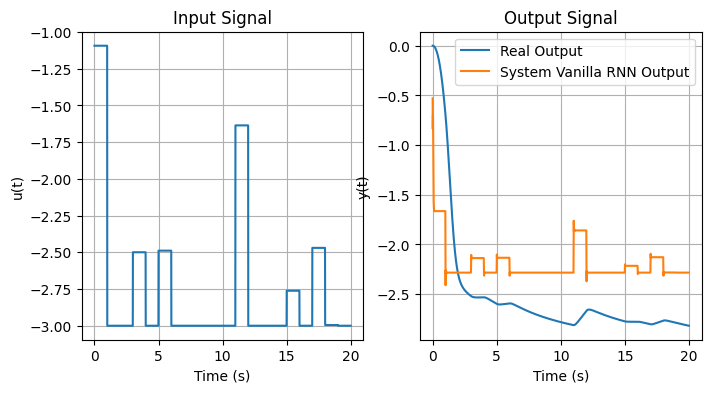

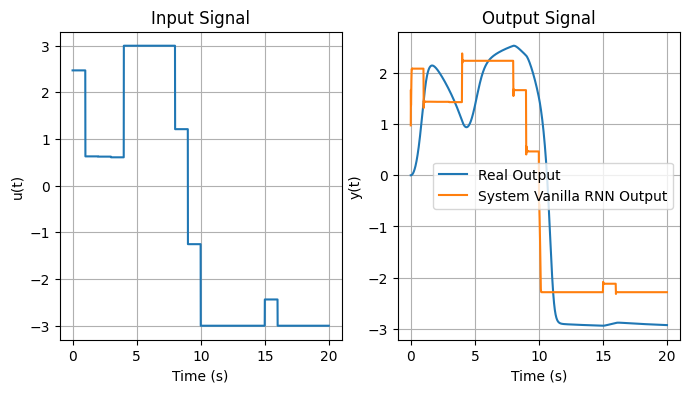

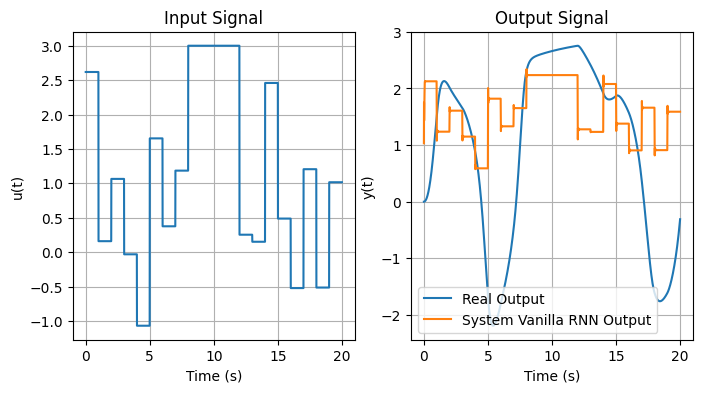

Training System Lstm RNN...
Total parameters: 162601
Trainable parameters: 162601
Total data items per batch: 240000
[0%] train loss: 3.787, val loss: 2.678
[0%] train loss: 2.039, val loss: 1.396
[1%] train loss: 1.568, val loss: 1.577
[1%] train loss: 1.499, val loss: 1.551
[1%] train loss: 1.392, val loss: 1.482
[2%] train loss: 1.394, val loss: 1.476
[2%] train loss: 1.493, val loss: 1.339
[2%] train loss: 1.446, val loss: 1.687
[3%] train loss: 1.497, val loss: 1.385
[3%] train loss: 1.835, val loss: 2.114
[3%] train loss: 2.058, val loss: 1.991
[4%] train loss: 1.944, val loss: 1.726
[4%] train loss: 1.547, val loss: 1.726
[4%] train loss: 1.678, val loss: 1.975
[5%] train loss: 2.294, val loss: 2.412
[5%] train loss: 2.305, val loss: 2.141
[5%] train loss: 1.934, val loss: 1.611
[6%] train loss: 1.999, val loss: 2.342
[6%] train loss: 1.707, val loss: 1.433
[6%] train loss: 1.498, val loss: 1.441
[7%] train loss: 1.408, val loss: 1.405
[7%] train loss: 1.386, val loss: 1.378
[7%

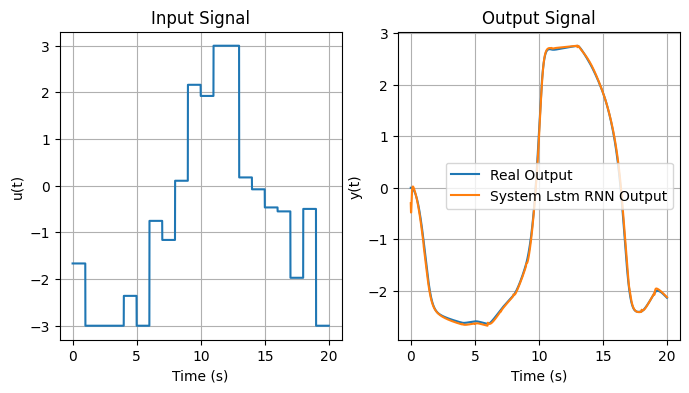

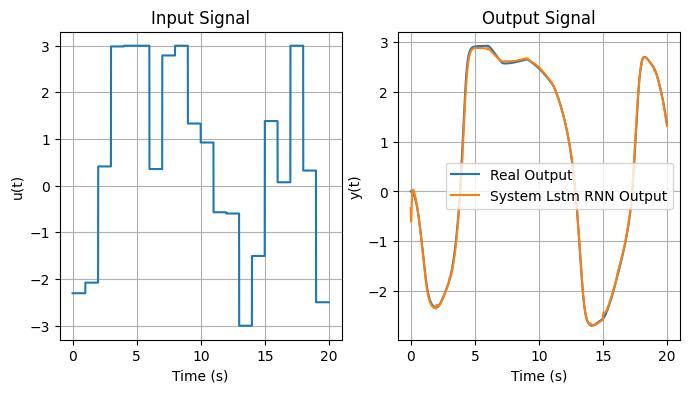

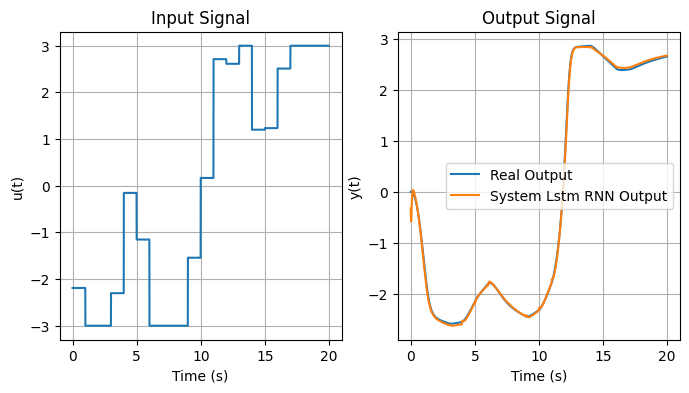

In [57]:
# Network types (Vanilla RNN and LSTM)
rnn_type_list = ["vanilla", "lstm"]

# Network parameter definition
nonlinearity = "tanh"
dropout = 0.0
num_layers = 1

for rnn_type in rnn_type_list:
    rnn_model = SystemRNN(
        num_layers=num_layers,
        nonlinearity=nonlinearity,
        dropout=dropout,
        rnn_type=rnn_type,
        name="System " + rnn_type.capitalize() + " RNN"
    ).to(DEVICE)
    sys_rnn_file_path = "./models/sys_" + rnn_type + ".pth"
    train_if_needed(rnn_model, sys_dataset, sys_rnn_file_path)

## Controller RNN

### Create PID Dataset

100%|██████████| 2000/2000 [00:17<00:00, 117.32it/s]


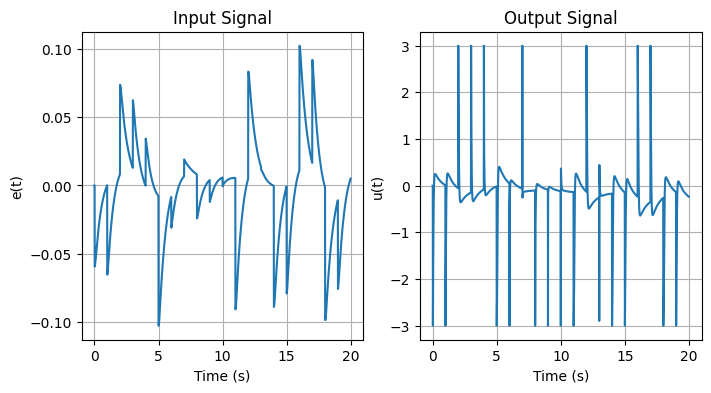

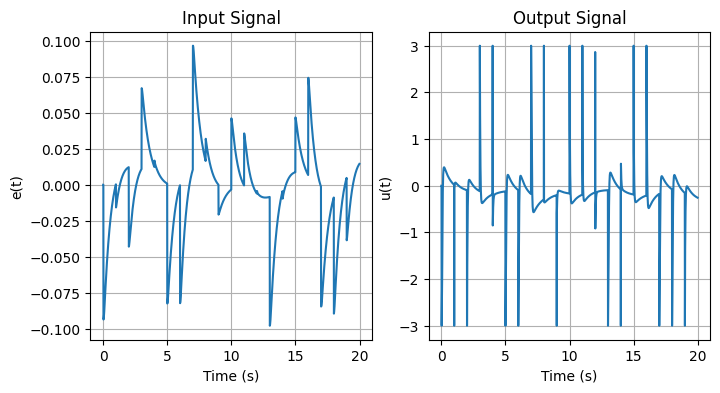

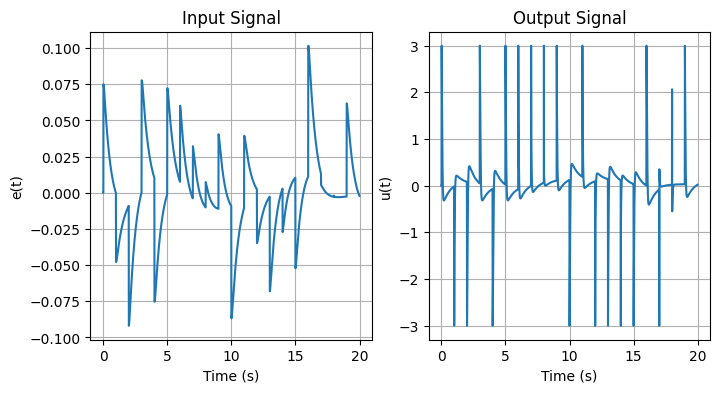

In [61]:
pid_dataset = (
    PIDDataset(
        van_der_pol_sys,
        pid,
        data_count=2000,
        num_steps=20,
        step_width=100,
        max_step_height=0.1,
        max_signal_val=3,
    )
    if not os.path.isfile(PID_DATASET_PATH)
    else torch.load(PID_DATASET_PATH)
)

plot_sample_signal_data(pid_dataset, num_samples=3, shuffle=True)

### Pre-train on the PID controller data

Training Controller RNN (Pretrained on PID)...
Total parameters: 162601
Trainable parameters: 162601
Total data items per batch: 240000
[0%] train loss: 0.244, val loss: 0.239
[0%] train loss: 0.242, val loss: 0.238
[1%] train loss: 0.241, val loss: 0.238
[1%] train loss: 0.241, val loss: 0.237
[1%] train loss: 0.240, val loss: 0.233
[2%] train loss: 0.236, val loss: 0.236
[2%] train loss: 0.238, val loss: 0.235
[2%] train loss: 0.237, val loss: 0.233
[3%] train loss: 0.235, val loss: 0.230
[3%] train loss: 0.232, val loss: 0.226
[3%] train loss: 0.224, val loss: 0.209
[4%] train loss: 0.207, val loss: 0.199
[4%] train loss: 0.197, val loss: 0.189
[4%] train loss: 0.188, val loss: 0.181
[5%] train loss: 0.180, val loss: 0.171
[5%] train loss: 0.170, val loss: 0.164
[5%] train loss: 0.162, val loss: 0.153
[6%] train loss: 0.149, val loss: 0.146
[6%] train loss: 0.146, val loss: 0.137
[6%] train loss: 0.195, val loss: 0.210
[7%] train loss: 0.191, val loss: 0.159
[7%] train loss: 0.157, 

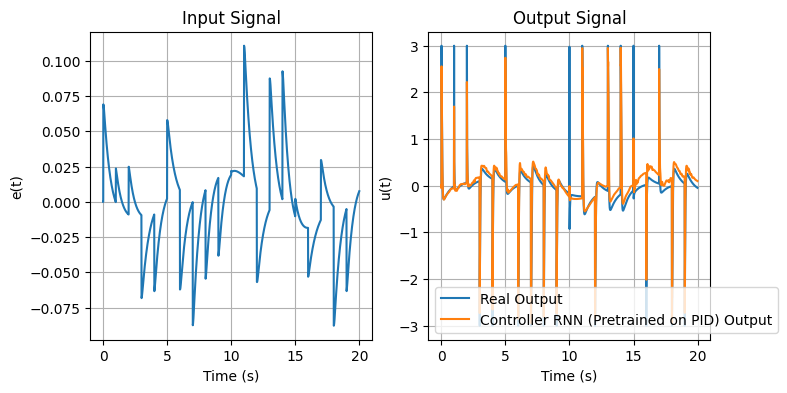

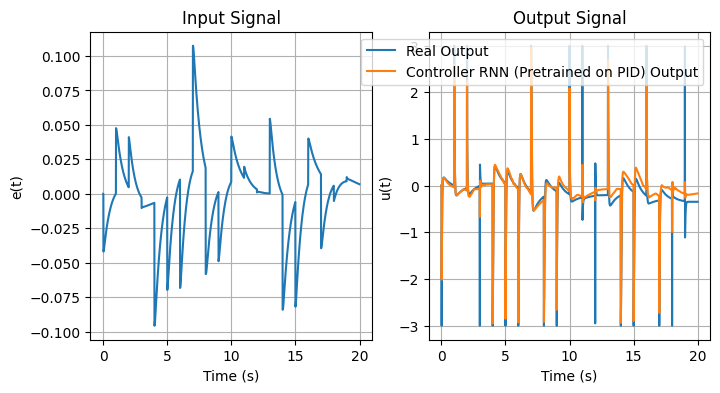

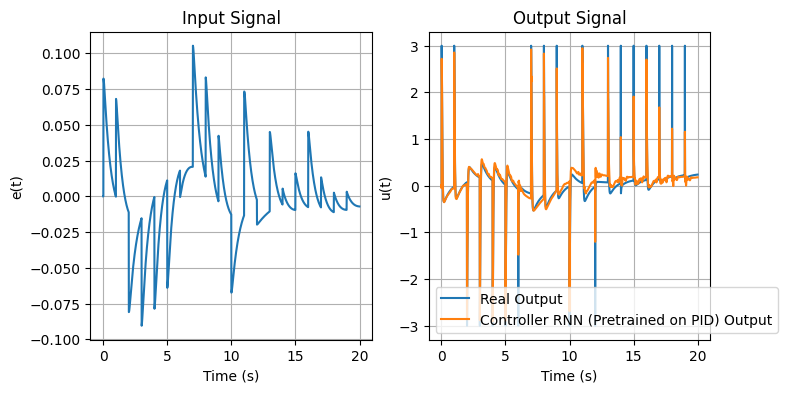

In [63]:
pid_rnn_file_path = "./models/pid_rnn.pth"
pid_rnn = ControllerRNN(
    out_min=-3,
    out_max=3,
    input_size=1,
    hidden_size=200,
    output_size=1,
    num_layers=1,
    nonlinearity="tanh",
    dropout=0.0,
    rnn_type="lstm",
    name="Controller RNN (Pretrained on PID)"
).to(DEVICE)
train_if_needed(pid_rnn, pid_dataset, pid_rnn_file_path)

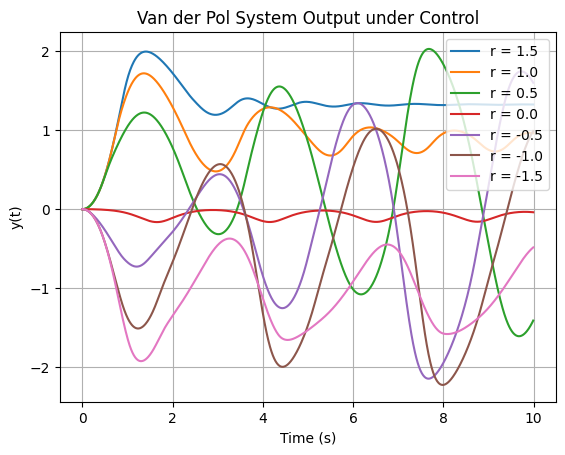

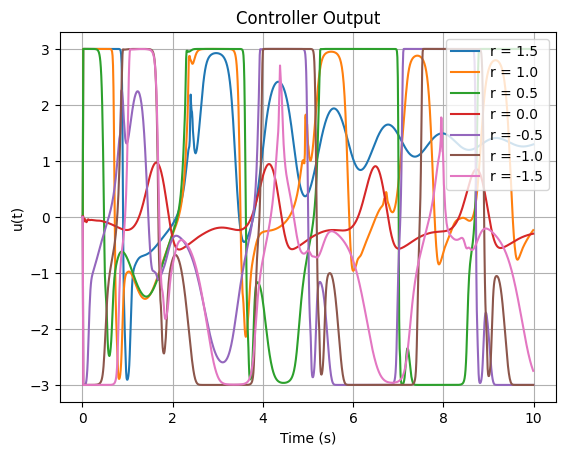

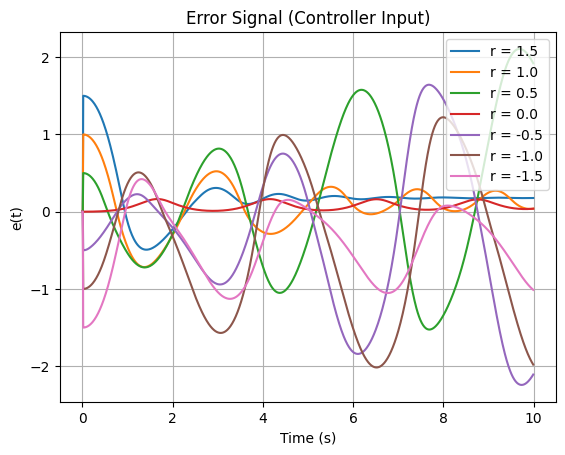

In [64]:
simulate_sys_with_controller(van_der_pol_sys, pid_rnn)

In [ ]:
# ts = np.arange(0, 20, .01)
# es = np.sin(ts)
# us_rnn = np.zeros(ts.shape)
# us_pid = np.zeros(ts.shape)

# us_rnn2 = pid_rnn(es) # No need to reset the RNN since the input is a sequence

# pid_rnn.reset()
# pid.reset()
# for i, e in enumerate(es):
#     us_rnn[i] = pid_rnn(e)
#     us_pid[i] = pid(e)

# plt.figure()
# plt.plot(ts, es)
# plt.figure()
# plt.plot(ts, us_rnn, label='rnn')
# plt.plot(ts, us_rnn2, label='rnn2')
# plt.plot(ts, us_pid, label='pid')
# plt.legend()


## Fine-tuning the Controller RNN using a Closed-loop System with System RNN

### Closed-loop RNN

### Closed-loop System Dataset

100%|██████████| 2000/2000 [00:00<00:00, 5855.64it/s]


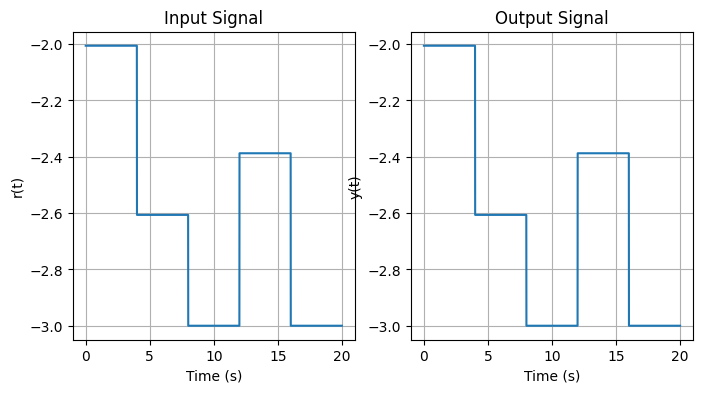

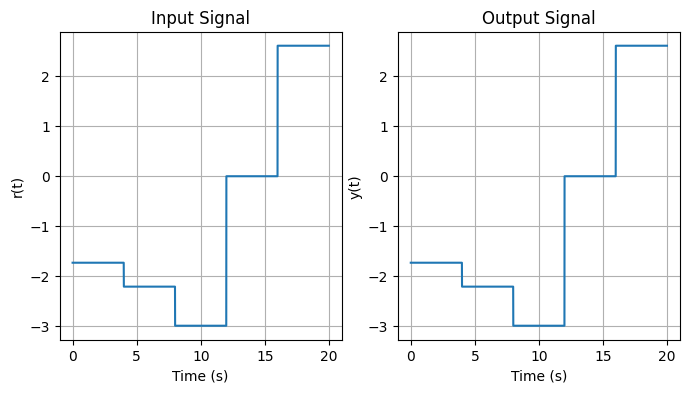

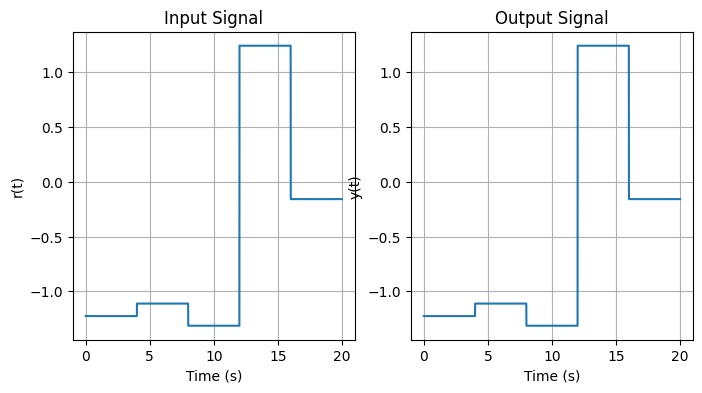

In [66]:
closed_loop_dataset = (
    ClosedLoopSysDataset(
        van_der_pol_sys,
        data_count=2000,
        num_steps=5,
        step_width=400,
        max_step_height=3,
        max_signal_val=3,
    )
    if not os.path.isfile(CLOSED_LOOP_SYS_DATASET_PATH)
    else torch.load(CLOSED_LOOP_SYS_DATASET_PATH)
)

plot_sample_signal_data(closed_loop_dataset, num_samples=3, shuffle=True)

### Fine-tuning

In [67]:
closed_loop_sys_rnn_file_path = "./models/closed_loop_sys_rnn.pth"
closed_loop_sys_rnn = ClosedLoopSysRNN(sys_rnn_file_path, pid_rnn_file_path, ref_size=1).to(DEVICE)
train_if_needed(closed_loop_sys_rnn, closed_loop_dataset, closed_loop_sys_rnn_file_path, learning_rate=.0001, epochs=10)

Training Closed Loop System RNN...
Total parameters: 325202
Trainable parameters: 162601
Total data items per batch: 240000


KeyboardInterrupt: 